In [1241]:
import pandas as pd
from category_encoders import LeaveOneOutEncoder
from matplotlib import pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression, TweedieRegressor
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
import seaborn as sns


In [1242]:
df = pd.read_csv('car_price_prediction.csv')

In [1243]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 19237 entries, 0 to 19236
Data columns (total 18 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   ID                19237 non-null  int64  
 1   Price             19237 non-null  int64  
 2   Levy              19237 non-null  object 
 3   Manufacturer      19237 non-null  object 
 4   Model             19237 non-null  object 
 5   Prod. year        19237 non-null  int64  
 6   Category          19237 non-null  object 
 7   Leather interior  19237 non-null  object 
 8   Fuel type         19237 non-null  object 
 9   Engine volume     19237 non-null  object 
 10  Mileage           19237 non-null  object 
 11  Cylinders         19237 non-null  float64
 12  Gear box type     19237 non-null  object 
 13  Drive wheels      19237 non-null  object 
 14  Doors             19237 non-null  object 
 15  Wheel             19237 non-null  object 
 16  Color             19237 non-null  object

В датасете относительно много данных и нет значений nan.
Непонятные колонки: Levy.
Стоит посмотреть колонки типа object на наличие "пропусков", бинарных или числовых типов.

In [1244]:
df["Levy"].unique()

array(['1399', '1018', '-', '862', '446', '891', '761', '751', '394',
       '1053', '1055', '1079', '810', '2386', '1850', '531', '586',
       '1249', '2455', '583', '1537', '1288', '915', '1750', '707',
       '1077', '1486', '1091', '650', '382', '1436', '1194', '503',
       '1017', '1104', '639', '629', '919', '781', '530', '640', '765',
       '777', '779', '934', '769', '645', '1185', '1324', '830', '1187',
       '1111', '760', '642', '1604', '1095', '966', '473', '1138', '1811',
       '988', '917', '1156', '687', '11714', '836', '1347', '2866',
       '1646', '259', '609', '697', '585', '475', '690', '308', '1823',
       '1361', '1273', '924', '584', '2078', '831', '1172', '893', '1872',
       '1885', '1266', '447', '2148', '1730', '730', '289', '502', '333',
       '1325', '247', '879', '1342', '1327', '1598', '1514', '1058',
       '738', '1935', '481', '1522', '1282', '456', '880', '900', '798',
       '1277', '442', '1051', '790', '1292', '1047', '528', '1211',
       

Levy перевод - сбор. Похоже на какой-то налог.
Учитывая что всего 9 уникальных значений, то это дискретная величина.

In [1245]:
df["Levy"].value_counts()

Levy
-       5819
765      486
891      461
639      410
640      405
        ... 
3156       1
2908       1
1279       1
1719       1
1901       1
Name: count, Length: 559, dtype: int64

In [1246]:
df["Levy"] = df["Levy"].replace("-", 0)
df = df.astype({"Levy": "int32"})

По информации с kaggle: "Tax of importing and exporting the cars."
Так же указано, что не определена валюта и смысл для "-".

Принял "-", как 0 и изменил тип колонки на числовой.

In [1247]:
df["Manufacturer"].value_counts()

Manufacturer
HYUNDAI          3769
TOYOTA           3662
MERCEDES-BENZ    2076
FORD             1111
CHEVROLET        1069
                 ... 
TESLA               1
PONTIAC             1
SATURN              1
ASTON MARTIN        1
GREATWALL           1
Name: count, Length: 65, dtype: int64

In [1248]:
df[df["Manufacturer"] == "სხვა"]

,ID,Price,Levy,Manufacturer,Model,Prod. year,Category,Leather interior,Fuel type,Engine volume,Mileage,Cylinders,Gear box type,Drive wheels,Doors,Wheel,Color,Airbags
2358,45779593,25089,0,სხვა,IVECO DAYLY,2007,Microbus,No,Diesel,2.3 Turbo,328000 km,4.0,Manual,Rear,04-May,Left wheel,White,1
4792,39223518,9408,0,სხვა,GONOW,2005,Jeep,Yes,Petrol,2.3,102000 km,4.0,Manual,Rear,04-May,Left wheel,Silver,2


Есть необычное значение "სხვა" в колонке Manufacturer.
Google определил как Грузинский язык. Перевод на английский other, что подходит по смыслу.
Какой шанс, что автор датасета Грузин?)

Удаляю строчки с სხვა в Manufacturer.

In [1249]:
df = df[df["Manufacturer"] != "სხვა"]

Заменяю бинарные классификации колонками булевых типов:

In [1250]:
df["Leather interior"] = pd.get_dummies(df["Leather interior"], drop_first=True)
df["Right_hand"] = pd.get_dummies(df["Wheel"], drop_first=True)
df = df.drop(["Wheel"], axis=1)

In [1251]:
# конвертирую float в int
df = df.astype({"Cylinders": "int32"})

Функции для конвертации колонок в числовые типы: Mileage, Engine volume.
Функция для колонки Turbo.

In [1252]:
def mileage_to_int(x: str) -> int:
    return int(x.replace(" km", ""))
df["Mileage"] = df["Mileage"].apply(mileage_to_int)


In [1253]:
def has_turbo(x: str) -> bool:
    return "Turbo" in x
df["Turbo"] = df["Engine volume"].apply(has_turbo)

In [1254]:
def engine_volume_to_float(x: str) -> float:
    return float(x.replace(" Turbo", ""))
df["Engine volume"] = df["Engine volume"].apply(engine_volume_to_float)

Колонки: Doors, Drive wheels, Gear box type привел к числовому формату.
Изменил имена колонок на более понятные и удалил Doors, Drive wheels, Gear.

In [1255]:
df = pd.concat([
    df,
    pd.get_dummies(df["Doors"], drop_first=True),
    pd.get_dummies(df["Drive wheels"], drop_first=True),
    pd.get_dummies(df["Gear box type"], drop_first=True),
], axis=1)
df = df.rename(columns={"04-May": "4 doors", ">5": ">5 doors"})
# удаляю модель, поскольку она объясняется другими признаками
df = df.drop(["Doors", "Drive wheels", "Gear box type", "Model"], axis=1)

In [1256]:
def predict_and_measure(model=None, drop_columns=None):
    if drop_columns is None:
        drop_columns = ["Price", "ID"]
    else:
        drop_columns = ["Price", "ID"] + drop_columns
    X_train, X_test, y_train, y_test = train_test_split(
        df.drop(drop_columns, axis=1),
        df["Price"],
        test_size=0.2,
        random_state=144,
        shuffle=True,
    )

    encoder_mm = LeaveOneOutEncoder()
    X_train['Manufacturer'] = encoder_mm.fit_transform(X_train['Manufacturer'], y_train)
    encoder_col = LeaveOneOutEncoder()
    X_train['Color'] = encoder_col.fit_transform(X_train['Color'], y_train)
    encoder_ft = LeaveOneOutEncoder()
    X_train['Fuel type'] = encoder_ft.fit_transform(X_train['Fuel type'], y_train)
    encoder_cat = LeaveOneOutEncoder()
    X_train['Category'] = encoder_cat.fit_transform(X_train['Category'], y_train)

    if model is None:
        model = LinearRegression()
    model.fit(X_train, y_train)

    X_test['Manufacturer'] = encoder_mm.transform(X_test['Manufacturer'], y_test)
    X_test['Color'] = encoder_col.transform(X_test['Color'], y_test)
    X_test['Fuel type'] = encoder_ft.fit_transform(X_test['Fuel type'], y_test)
    X_test['Category'] = encoder_cat.fit_transform(X_test['Category'], y_test)

    prediction = model.predict(X_test)

    return (
        mean_squared_error(y_test, prediction),
        mean_absolute_error(y_test, prediction),
        r2_score(y_test, prediction),
    )


In [1257]:
predict_and_measure()

(379111236.6137493, 12951.482086170623, -0.1214373328422691)

Можно с уверенностью сказать, что цену модель не объясняет.
Стоит поработать с выбросами в колонке цены, поскольку mse очень высокое.

In [1258]:
df["Price"].describe().T

count    1.923500e+04
mean     1.855606e+04
std      1.905912e+05
min      1.000000e+00
25%      5.331000e+03
50%      1.317200e+04
75%      2.206900e+04
max      2.630750e+07
Name: Price, dtype: float64

In [1259]:
df["Price"].sort_values(ascending=True).tail(20)

2912       172486
2768       172486
6468       172486
9248       172486
4722       175622
13328      193184
1145       194438
7353       216391
2283       219527
7283       228935
15283      250574
5840       254024
10759      260296
7749       288521
14839      297930
9367       297930
5008       308906
1225       627220
8541       872946
16983    26307500
Name: Price, dtype: int64

Смотрим количество машин в группах по 100к

In [1260]:
(
    len(df[df.Price <= 100000]),
    len(df[(df.Price > 100000) & (df.Price <= 200000)]),
    len(df[df.Price > 200000]),
)

(19122, 100, 13)

In [1261]:
#Для начала отбросим все свыше 100к
df = df[(df.Price < 100000)]

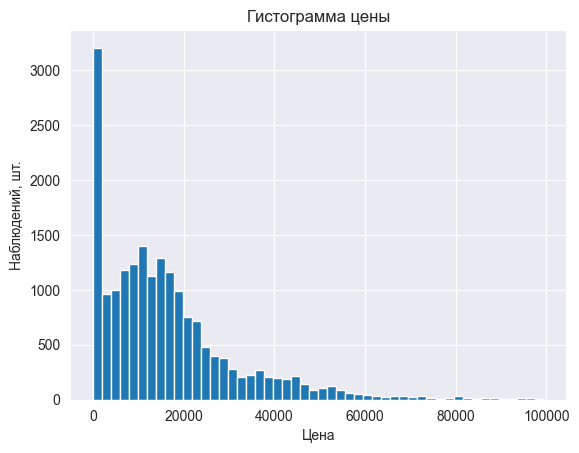

In [1262]:
plt.title("Гистограмма цены")
plt.xlabel("Цена")
plt.ylabel("Наблюдений, шт.")
plt.hist(df["Price"], bins=50);

In [1263]:
df["Price"].sort_values(ascending=False).tail(20)

12917    6
18575    6
5344     6
5890     3
8993     3
17596    3
11636    3
753      3
14492    3
4776     3
221      3
14642    3
4958     3
10885    3
13419    3
15347    3
7276     3
9730     3
16992    1
7815     1
Name: Price, dtype: int64

In [1264]:
(
    len(df[df.Price <= 1000]),
    len(df[(df.Price > 1000) & (df.Price <= 2000)]),
    len(df[(df.Price > 2000) & (df.Price <= 3000)]),
    len(df[(df.Price > 3000) & (df.Price <= 4000)]),
    len(df[(df.Price > 4000) & (df.Price <= 5000)]),
    len(df[(df.Price > 5000) & (df.Price <= 6000)]),
    len(df[(df.Price > 6000) & (df.Price <= 7000)]),
    len(df[(df.Price > 7000) & (df.Price <= 8000)]),
    len(df[(df.Price > 8000) & (df.Price <= 9000)]),
    len(df[(df.Price > 10000) & (df.Price <= 11000)]),
)

(2585, 627, 436, 526, 452, 544, 540, 692, 569, 791)

Значения меньше 1000 являются выбросом с количественной точки зрения.
Может создать отдельную модель для значений меньше 1000?
Посмотрим эту тысячу по сотням.

In [1265]:
(
    len(df[df.Price <= 100]),
    len(df[(df.Price > 100) & (df.Price <= 200)]),
    len(df[(df.Price > 200) & (df.Price <= 300)]),
    len(df[(df.Price > 300) & (df.Price <= 400)]),
    len(df[(df.Price > 400) & (df.Price <= 500)]),
    len(df[(df.Price > 500) & (df.Price <= 600)]),
    len(df[(df.Price > 600) & (df.Price <= 700)]),
    len(df[(df.Price > 700) & (df.Price <= 800)]),
    len(df[(df.Price > 800) & (df.Price <= 900)]),
    len(df[(df.Price > 1000) & (df.Price <= 1100)]),
)

(381, 279, 240, 487, 278, 185, 196, 278, 122, 125)

In [1266]:
#Аналогично отбросим все ниже 1000
df = df[(df.Price >= 1000)]

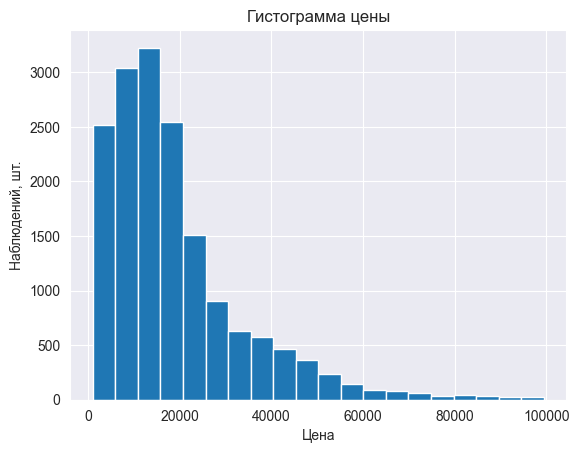

In [1267]:
plt.title("Гистограмма цены")
plt.xlabel("Цена")
plt.ylabel("Наблюдений, шт.")
plt.hist(df["Price"], bins=20);

Похожие распределения: Negative Binomial

*Ремарка: если увеличивать количество бинов, то похожесть уходит, много локальных пиков.

In [1268]:
predict_and_measure()

(149234213.00918543, 8645.064757976801, 0.3599183626933473)

Метрика выросла, но в большинстве случаев мы все-таки ни как не объясняем цену.

Попробуем посмотреть зависимости признаков с целевым.

In [1269]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 16548 entries, 0 to 19235
Data columns (total 22 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   ID                16548 non-null  int64  
 1   Price             16548 non-null  int64  
 2   Levy              16548 non-null  int32  
 3   Manufacturer      16548 non-null  object 
 4   Prod. year        16548 non-null  int64  
 5   Category          16548 non-null  object 
 6   Leather interior  16548 non-null  bool   
 7   Fuel type         16548 non-null  object 
 8   Engine volume     16548 non-null  float64
 9   Mileage           16548 non-null  int64  
 10  Cylinders         16548 non-null  int32  
 11  Color             16548 non-null  object 
 12  Airbags           16548 non-null  int64  
 13  Right_hand        16548 non-null  bool   
 14  Turbo             16548 non-null  bool   
 15  4 doors           16548 non-null  bool   
 16  >5 doors          16548 non-null  bool   
 17

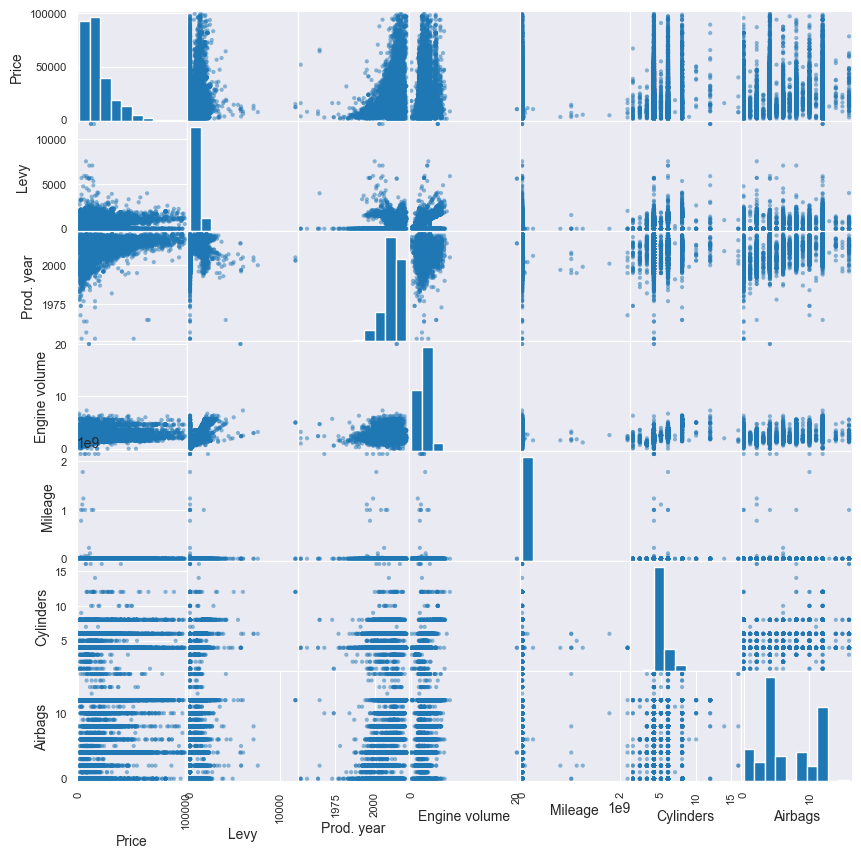

In [1270]:
pd.plotting.scatter_matrix(
    df[["Price", "Levy", "Prod. year", "Engine volume", "Mileage", "Cylinders", "Airbags"]],
    figsize=(10,10)
);

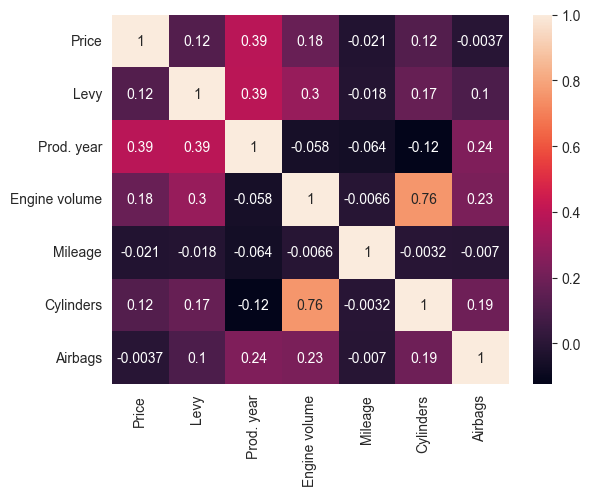

In [1271]:
sns.heatmap(df[["Price", "Levy", "Prod. year", "Engine volume", "Mileage", "Cylinders", "Airbags"]].corr(), annot=True);

Сильной линейной зависимости нет. На графиках зависимость есть, не линейная.
Engine volume и Сylinders линейно зависимы стоит ли удалить один из них?
Как оценивать связи с бинарными значениями?

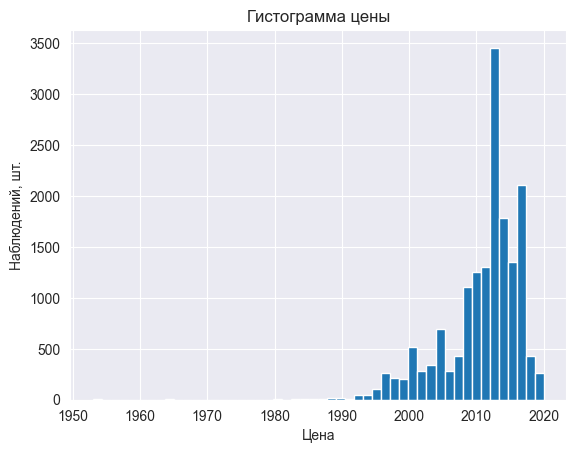

In [1272]:
plt.title("Гистограмма цены")
plt.xlabel("Цена")
plt.ylabel("Наблюдений, шт.")
plt.hist(df["Prod. year"], bins=50);

In [1273]:
df["Prod. year"].value_counts()

Prod. year
2012    1796
2014    1787
2013    1660
2015    1349
2016    1329
2011    1306
2010    1252
2017     780
2008     559
2009     546
2007     425
2018     425
2005     355
2004     339
2003     338
2006     284
2002     280
2000     272
2001     245
2019     223
1998     209
1999     204
1997     149
1996     112
1995     104
1994      42
2020      41
1992      29
1993      22
1990      17
1988      11
1991      10
1989       6
1986       6
1987       5
1985       4
1984       4
1953       3
1983       3
1964       2
1974       2
1977       2
1978       2
1965       2
1980       2
1957       1
1968       1
1982       1
1981       1
1973       1
Name: count, dtype: int64

In [1274]:
translations = {
    'Price' : 'Цена',
    'Prod. year' : 'Дата производства',
}

def visualize(column, xlim=None):
    xlabel = translations.get(column.name, column.name)
    fig, axes = plt.subplots(1, 2, figsize=(16,6))
    sns.histplot(column, ax=axes[0], bins=25, kde=False)
    axes[0].set(title='Гистограмма', xlabel=xlabel, ylabel='Наблюдений, шт.', xlim=xlim);
    sns.violinplot(column, ax=axes[1], orient='h')
    axes[1].set(title='Плотность и размах', xlabel=xlabel, xlim=xlim);

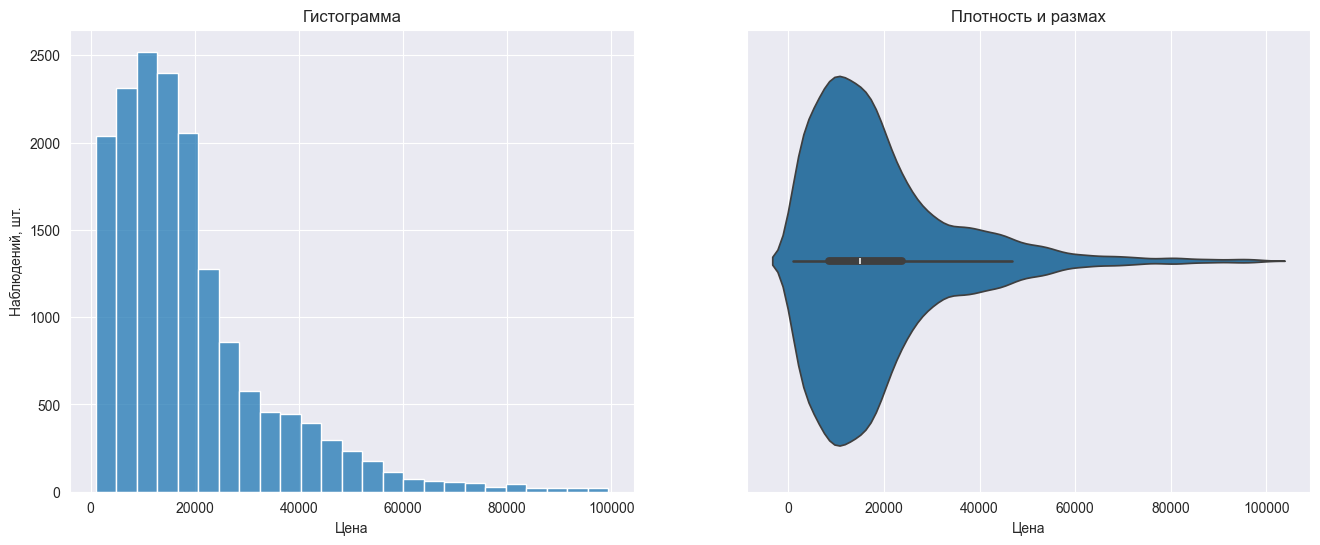

In [1275]:
visualize(df["Price"])

In [1276]:
len(df[df["Prod. year"] < 1990])

59

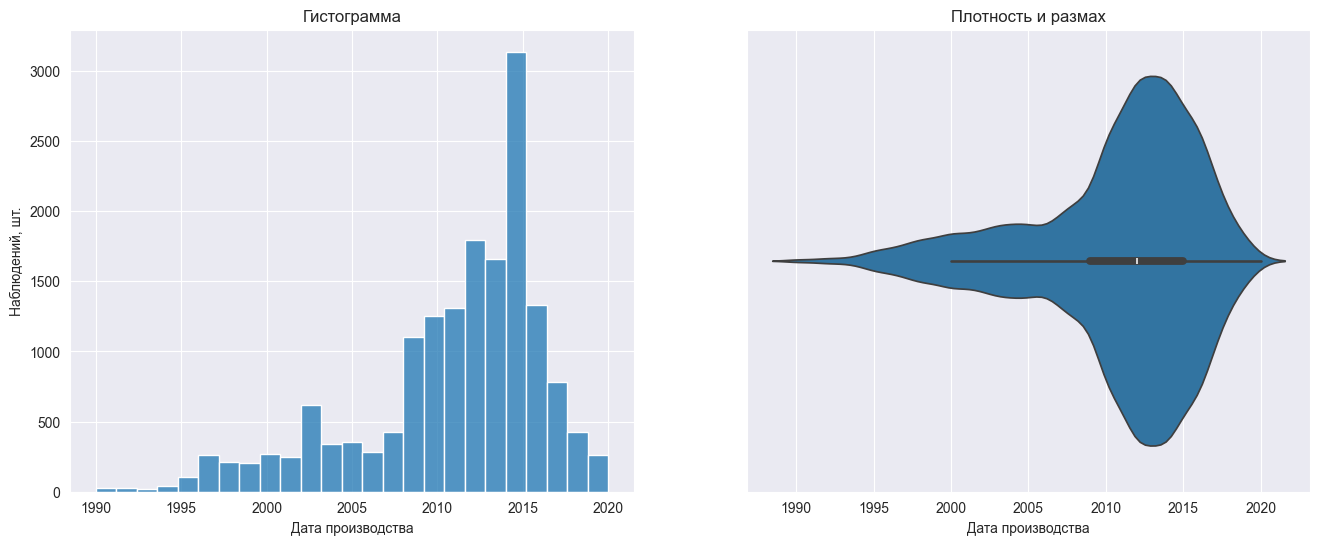

In [1277]:
visualize(df[df["Prod. year"] >= 1990]["Prod. year"])

In [1278]:
len(df[df["Engine volume"] > 6])

17

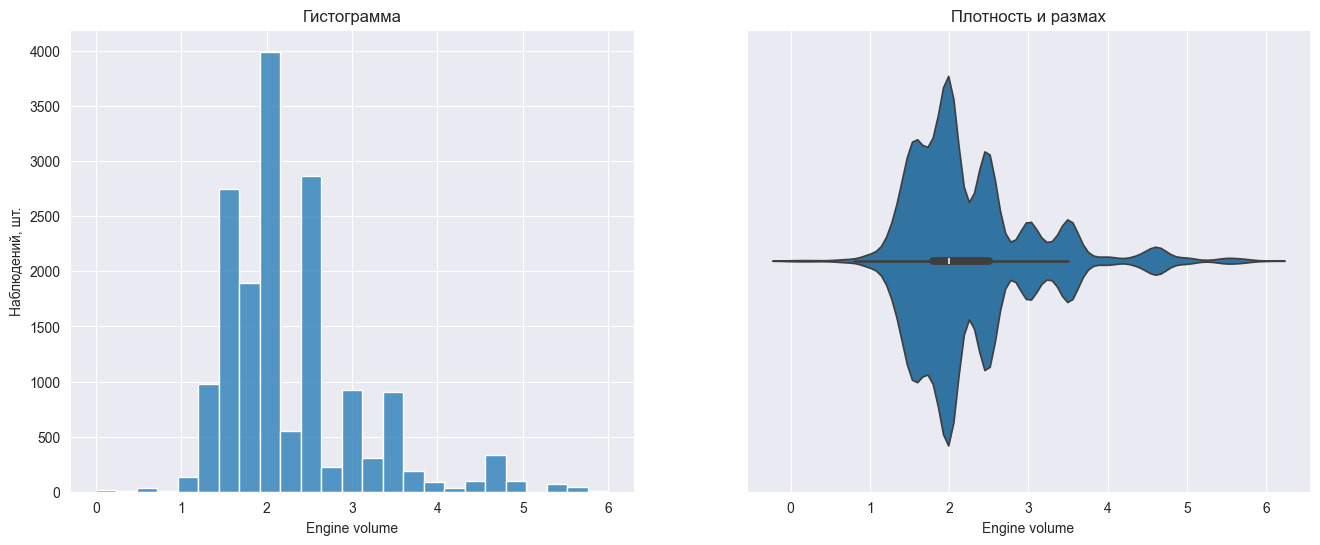

In [1279]:
visualize(df[df["Engine volume"] <= 6]["Engine volume"])

Очистить от выбросов по пробегу(Mileage) проблематично в отрыве от года производства(Prod. year).
Создадим столбец пробег в км/ч (Mileage km/h) из предположения, что в день машина использовалась по 12 часов.

In [1280]:
df["Mileage km/h"] = df["Mileage"]/((2023 - df["Prod. year"]) * 365 * 12)
df["Mileage km/h"]

0        3.266684
1        3.652968
2        2.686006
3        3.214726
4        2.331329
           ...   
19231    2.461187
19232    2.853881
19233    3.074581
19234    2.043642
19235    0.731421
Name: Mileage km/h, Length: 16548, dtype: float64

In [1281]:
df["Mileage km/h"].sort_values().tail(50)

18393       28.180039
5866        28.227480
10455       28.538813
18950       28.538813
5346        29.680365
9140        30.040856
5860        31.392694
14235       32.697326
10026       33.157710
16733       33.251005
1806        33.823778
18846       34.199899
493         36.529680
3604        36.529680
3895        37.016743
10077       40.549087
11266       46.100220
7429        52.849610
14134       52.968037
7000        69.069817
9330        77.264703
8858        79.274479
1146        88.787523
4823        90.245762
1892        97.568590
2512        98.807699
11430      115.308333
8824       196.406230
9542       240.326845
11472      291.730086
17206      338.237781
11144      473.001370
1404       604.008100
18477     1207.992074
15364     2984.451007
985       6829.801344
12591     8153.946502
12904     8781.173156
12734     8914.419456
19199     9059.940566
7724     11744.367380
5456     12016.342213
16586    14269.406378
10667    15220.700137
6157     17510.466789
17582    1

Начиная с 130 км/ч и выше числа выглядят не реалистично.
Предположение о 18 часах в день и так не маленькое и осуществимо только посменно.
Поэтому отбросим эти значения.

In [1282]:
len(df[(df["Mileage km/h"] == 0) | (df["Mileage km/h"] > 5)])

2011

In [1283]:
df = df[(df["Mileage km/h"] > 0) & (df["Mileage km/h"] < 5)]

In [1284]:
df[["Prod. year", "Mileage", "Mileage km/h"]].sort_values(by="Mileage km/h").tail(100)

,Prod. year,Mileage,Mileage km/h
9729,2016,149361,4.871526
18722,2014,192122,4.873719
17799,2011,256175,4.873954
11322,2016,149476,4.875277
1686,2008,320582,4.879482
...,...,...,...
16613,2017,131200,4.992390
16715,2012,240560,4.992943
17878,2015,175126,4.997888
17066,2011,262690,4.997907


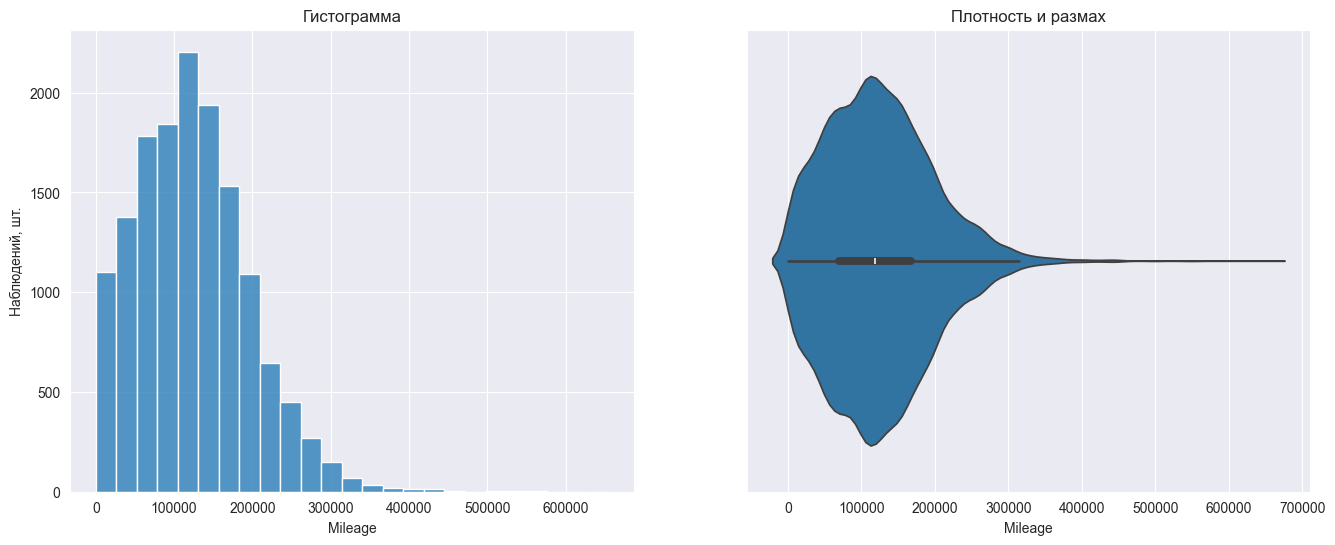

In [1285]:
visualize(df["Mileage"])

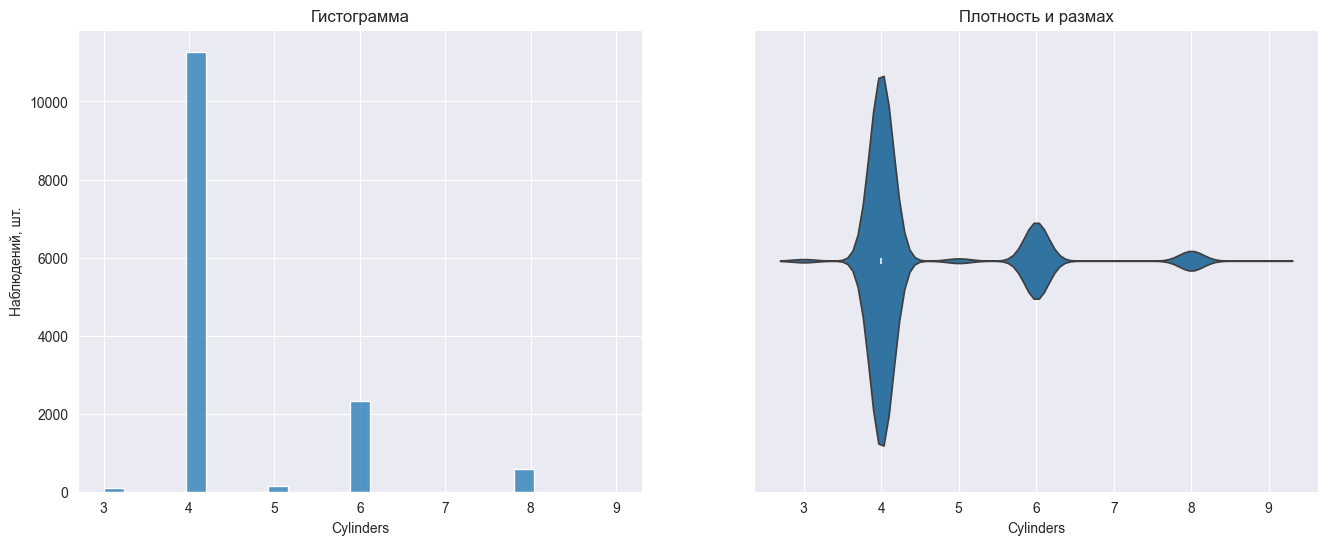

In [1286]:
df = df[(df["Cylinders"] > 2) & (df["Cylinders"] <= 9)]
visualize(df["Cylinders"])

In [1287]:
df = df[df["Airbags"] < 13]

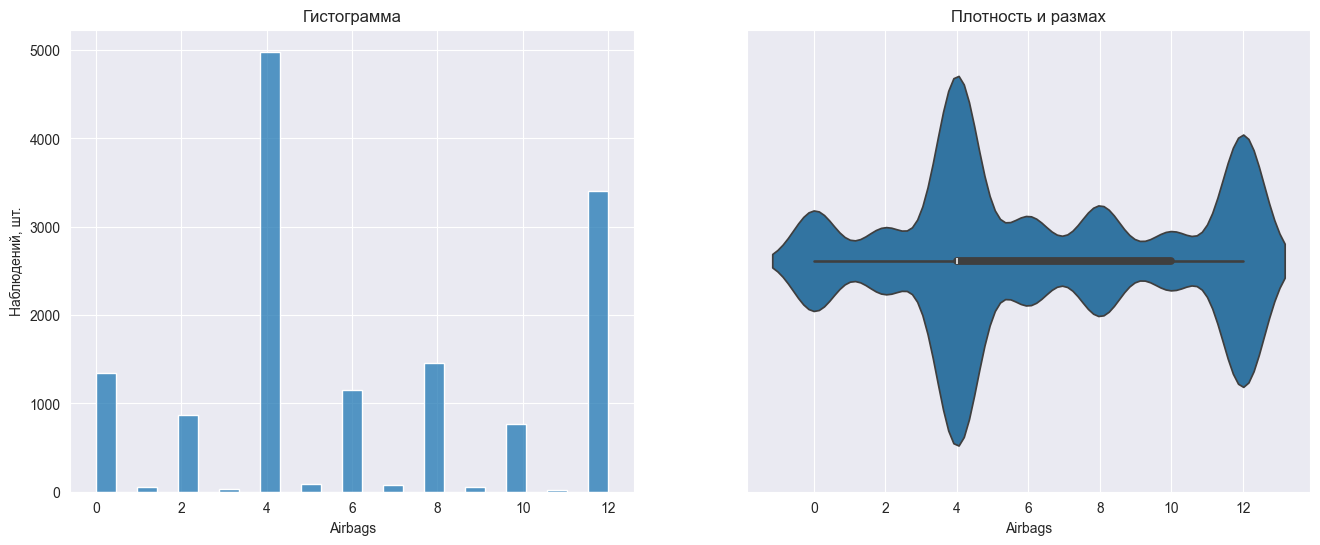

In [1288]:
visualize(df["Airbags"])

In [1289]:
predict_and_measure()

(147027008.35644352, 8713.3587955826, 0.40731926894170634)

Попробуем найти зависимости цены и категориальных признаков рассчитав среднее по категории.

In [1290]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 14323 entries, 0 to 19235
Data columns (total 23 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   ID                14323 non-null  int64  
 1   Price             14323 non-null  int64  
 2   Levy              14323 non-null  int32  
 3   Manufacturer      14323 non-null  object 
 4   Prod. year        14323 non-null  int64  
 5   Category          14323 non-null  object 
 6   Leather interior  14323 non-null  bool   
 7   Fuel type         14323 non-null  object 
 8   Engine volume     14323 non-null  float64
 9   Mileage           14323 non-null  int64  
 10  Cylinders         14323 non-null  int32  
 11  Color             14323 non-null  object 
 12  Airbags           14323 non-null  int64  
 13  Right_hand        14323 non-null  bool   
 14  Turbo             14323 non-null  bool   
 15  4 doors           14323 non-null  bool   
 16  >5 doors          14323 non-null  bool   
 17

In [1291]:
df.groupby("Variator")["Price"].mean()

Variator
False    19642.412324
True     15390.970405
Name: Price, dtype: float64

In [1292]:
df.groupby("Tiptronic")["Price"].mean()

Tiptronic
False    18345.280569
True     24176.550773
Name: Price, dtype: float64

In [1293]:
df.groupby("Manual")["Price"].mean()

Manual
False    20363.319325
True     11780.165680
Name: Price, dtype: float64

У типов коробки передач явно есть зависимость Tiptronic > Variator > Manual

In [1294]:
df.groupby("Rear")["Price"].mean()

Rear
False    19662.855108
True     17940.788034
Name: Price, dtype: float64

In [1295]:
df.groupby("Front")["Price"].mean()

Front
False    20329.078241
True     19073.000900
Name: Price, dtype: float64

У привода зависимость слабая, стоит попробовать посчитать модель без признаков: Rear и Front

In [1296]:
df.groupby(">5 doors")["Price"].mean()

>5 doors
False    19422.619945
True     23448.201923
Name: Price, dtype: float64

In [1297]:
df.groupby("4 doors")["Price"].mean()

4 doors
False    16374.155263
True     19624.307896
Name: Price, dtype: float64

Количество дверей - слабая зависимость. 16374 / 19624 = 0.83 и 19422 / 23446 = 0.83

In [1298]:
df.groupby("Turbo")["Price"].mean()

Turbo
False    18724.730642
True     25071.183425
Name: Price, dtype: float64

In [1299]:
df.groupby("Right_hand")["Price"].mean()

Right_hand
False    20361.778499
True      9808.817004
Name: Price, dtype: float64

In [1300]:
df.groupby("Leather interior")["Price"].mean()

Leather interior
False    14127.468357
True     21856.374481
Name: Price, dtype: float64

Признаки: Turbo, Right_hand и Leather interior показывают явную зависимость.

In [1301]:
predict_and_measure(drop_columns=["Rear", "Front", ">5 doors", "4 doors"])

(147207113.7424087, 8722.137985284493, 0.40659324592719615)

Незначительное понижение r_score (0.001) оправдывает потерю 4 признаков.
Как оценить зависимость с ценой колонок: Manufacturer, Color, Fuel type и Category?

Следующим шагом попробую использовать TweedieRegressor.

In [1306]:
predict_and_measure(
    model=TweedieRegressor(max_iter=1000),
    drop_columns=["Rear", "Front", ">5 doors", "4 doors"],
)

/home/ptsvirko/anaconda3/envs/linear_regresion/lib/python3.8/site-packages/sklearn/linear_model/_glm/glm.py:282: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res)


(177428275.94334087, 9439.380941468142, 0.28476868656966525)

Метрика понизилась, на 10000 итераций модель обучается непростительно долго.
Почему TweedieRegressor это экспоненциальное распределение ведь его power может быть: Normal, Poisson, Gamma и Inverse Gaussian?